# XLM-RoBERTa
*Time for run all (GPU): ~4 hours*

## 1. General Settings and Import Libraries

In [ ]:
!git clone https://github.com/helloitsurdvq/StockReview.IntroAI.20222.git

In [ ]:
%ls StockReview.IntroAI.20222/source/data/

In [ ]:
%cd StockReview.IntroAI.20222/

In [ ]:
%cd source/

In [1]:
!pip install torchtext

In [1]:
import pprint
import numpy as np
import pandas as pd

from sklearn import preprocessing, metrics

import torch
from torch import Tensor
from torch.utils.data import DataLoader
from torch.optim import AdamW
import torchtext
import torchtext.transforms as T
import torchtext.functional as F
from torchtext.models import RobertaClassificationHead, XLMR_BASE_ENCODER

import pickle

c:\Users\DELL\Programming\python\StockReview.IntroAI.20222\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Data Preparation 

In [2]:
train_df = pd.read_json('data/stock_train.json')
test_df = pd.read_json('data/stock_test.json')

In [3]:
train_df

,text,label,label_id
0,"Tại thị trường trong nước, khảo sát lúc 9 giờ ...",positive,0
1,tăng 50.000 đồng/lượng ở cả hai chiều mua và b...,positive,0
2,Tại 2 thị trường lớn khác là Hà Nội và Đà Nẵng...,positive,0
3,Vàng lại bật tăng vượt ngưỡng 2.000 USD/ounce,positive,0
4,tăng 24 USD/ounce so với cùng giờ sáng qua,positive,0
...,...,...,...
1511,Danh mục đầu tư 60/40 là mô hình phân chia tài...,neutral,2
1512,"Theo tính toán của Vanguard, lợi nhuận hàng nă...",neutral,2
1513,Nhóm chuyên gia JP Morgan xem xét 200 loại tài...,neutral,2
1514,Kết luận đưa ra là các nguyên tắc cốt lõi của ...,neutral,2


In [4]:
test_df

,text,label,label_id
0,Tại 2 thị trường lớn khác là Hà Nội và Đà Nẵng...,positive,0
1,"Như vậy, trong 2 ngày qua, giá vàng nhẫn đã tă...",positive,0
2,"Giá vàng thế giới bật tăng trở lại, khi lực cầ...",positive,0
3,"Tại thị trường thế giới, thời điểm lúc 9 giờ 3...",positive,0
4,"Tuy nhiên, sau đó lực cầu bắt đáy mạnh đã giúp...",positive,0
...,...,...,...
997,"Ngoài 47 triệu cổ phiếu khớp lệnh, HAG còn ghi...",neutral,2
998,báo cáo giải trình của SHS cho biết,neutral,2
999,"Cuối quý I, SHS nắm giữ 2.240 tỷ đồng cổ phiếu...",neutral,2
1000,SHS còn nắm giữ hơn 420 tỷ đồng TCB với giá tr...,neutral,2


In [5]:
from pyvi import ViTokenizer
def clean_text(text):
    text = text.lower()
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^,_' + "'`"
    for p in punctuations:
        text = text.replace(p,'')
    text = ViTokenizer.tokenize(text)
    return text

In [ ]:
train_df['text'] = train_df['text'].apply(clean_text)
test_df['text'] = test_df['text'].apply(clean_text)

In [5]:
label_encoder = preprocessing.LabelEncoder()
train_df['label'] = label_encoder.fit_transform(train_df['label'])

In [6]:
test_df['label'] = label_encoder.transform(test_df['label'])

In [7]:
class PadTransform(torch.nn.Module):
    """Pad tensor to a fixed length with given padding value.
    :param max_length: Maximum length to pad to
    :type max_length: int
    :param pad_value: Value to pad the tensor with
    :type pad_value: bool
    """

    def __init__(self, max_length: int, pad_value: int) -> None:
        super().__init__()
        self.max_length = max_length
        self.pad_value = float(pad_value)
        
    def forward(self, x: Tensor) -> Tensor:
        """
        :param x: The tensor to pad
        :type x: Tensor
        :return: Tensor padded up to max_length with pad_value
        :rtype: Tensor
        """
        max_encoded_length = x.size(-1)
        if max_encoded_length < self.max_length:
            pad_amount = self.max_length - max_encoded_length
            x = torch.nn.functional.pad(x, (0, pad_amount), value=self.pad_value)
        return x

In [8]:
padding_idx = 1
bos_idx = 0
eos_idx = 2
max_seq_len = 256

In [9]:
text_transform = torchtext.models.XLMR_LARGE_ENCODER.transform()

In [10]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.df = df
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        return (
            torch.tensor(text_transform(self.df.iloc[idx, 0])),
            torch.tensor(self.df.iloc[idx, 1])
        )

In [11]:
train_dataset = CustomDataset(train_df)
test_dataset = CustomDataset(test_df)

In [12]:
SMALL_BATCH_SIZE = 16
K = 2
LARGE_BATCH_SIZE = K * SMALL_BATCH_SIZE

In [14]:
def batch_collate_fn(batch):
    inp_list = list()
    tar_list = list()
    
    for sample in batch:
        inp_list.append(sample[0].tolist())
        tar_list.append(sample[1])
        
    padded_tensor = F.to_tensor(inp_list, padding_value=padding_idx)
    target_tensor = torch.stack(tar_list).type(torch.LongTensor)
    
    return padded_tensor, target_tensor

In [15]:
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=SMALL_BATCH_SIZE,
    shuffle=True,
    collate_fn=batch_collate_fn
)

In [16]:
test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=SMALL_BATCH_SIZE,
    shuffle=False,
    collate_fn=batch_collate_fn
)

In [17]:
num_classes = 3
input_dim = 768

In [18]:
classifier_head = RobertaClassificationHead(num_classes=num_classes, input_dim=input_dim)
model = XLMR_BASE_ENCODER.get_model(head=classifier_head)

In [19]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [20]:
model.to(DEVICE)
pass  

In [21]:
learning_rate = 1.2e-5 
optim = AdamW(model.parameters(), lr=learning_rate)
criteria = torch.nn.CrossEntropyLoss()

## 3. Model Training and Evaluation

In [22]:
def train_step(input, target, small_batch_no):
    output = model(input)
    loss = criteria(output, target)
    loss.backward()
    
    if (small_batch_no + 1) % K == 0 or (small_batch_no + 1) == len(train_dataloader):
        optim.step()
        optim.zero_grad()
    
    return loss.item() / input.size(dim=0)

def evaluate():
    model.eval()
    total_loss = 0
    counter = 0
    
    with torch.no_grad():
        for i, batch in enumerate(test_dataloader):
            input = batch[0].clone().detach().to(DEVICE)
            output = model(input)
            target = batch[1].clone().detach().to(DEVICE)
            
            if i == 0:
                class_output = torch.argmax(output, dim=1)
                class_target = target
            else:
                class_output = torch.cat([class_output, torch.argmax(output, dim=1)])
                class_target = torch.cat([class_target, target])
            
            loss = criteria(output, target).item()
            total_loss += loss
            counter += input.size(dim=0)
            
            
        confusion_matrix = metrics.confusion_matrix(
            class_target.cpu().numpy().flatten(),
            class_output.cpu().numpy().flatten(),
            labels=[0, 1, 2]
        ) 
        classification_report = metrics.classification_report(
            class_target.cpu().numpy().flatten(),
            class_output.cpu().numpy().flatten(),
            labels=[0, 1, 2],
            output_dict=True
        )

    return (
        total_loss,
        counter,
        confusion_matrix,
        classification_report
    )

In [23]:
num_epochs = 20

In [24]:
def save_log(epoch, **kwargs):
    with open(f'log_{epoch}.pkl', 'wb') as f:
        pickle.dump(kwargs, f)

def save_model(message):
    torch.save(model.state_dict(), f'model_{message}.pth')
    print('Model saved successfully')

In [25]:
max_accuracy = float('-inf')
max_macro_f1 = float('-inf')
max_weighted_f1 = float('-inf')

In [26]:
for epoch in range(num_epochs):
    model.train()
    avg_training_losses = list()
    
    for small_batch_no, small_batch in enumerate(train_dataloader):
        input = small_batch[0].clone().detach().to(DEVICE)
        target = small_batch[1].clone().detach().to(DEVICE)
        avg_training_losses.append(
            train_step(input, target, small_batch_no)
        )
        torch.cuda.empty_cache()

    total_loss, counter, confusion_matrix, classification_report = evaluate()
    print(f'EPOCH {epoch}')
    print(f'Mean of avg_training_losses={np.mean(avg_training_losses)}')
    print(f'total_loss={total_loss}')
    print(f'counter={counter}')
    print(f'loss=total_loss/counter={total_loss/counter}')
    print(f'confusion_matrix=\n{confusion_matrix}')
    print('classification_report=')
    pprint.pprint(classification_report)
    
    save_log(
        epoch,
        avg_training_losses=avg_training_losses,
        total_loss=total_loss,
        counter=counter,
        loss=total_loss/counter,
        confusion_matrix=confusion_matrix,
        classification_report=classification_report
    )
    
    if classification_report['accuracy'] > max_accuracy:
        print(f'New max_accuracy')
        max_accuracy = classification_report['accuracy']
        max_accuracy_index = epoch
        save_model('max_accuracy')
        
    elif classification_report['macro avg']['f1-score'] > max_macro_f1:
        print(f'New max_macro_f1')
        max_macro_f1 = classification_report['macro avg']['f1-score']
        max_macro_f1_index = epoch
        save_model('max_macro_f1')
    
    elif classification_report['weighted avg']['f1-score'] > max_weighted_f1:
        print(f'New max_weighted_f1')
        max_weighted_f1 = classification_report['weighted avg']['f1-score']
        max_weighted_f1_index = epoch
        save_model('max_weighted_f1')
    
    elif epoch == num_epochs - 1:
        save_model(f'{epoch}_last')
    
    elif epoch % 40 == 0:
        save_model(f'{epoch}_checkpoint')
        
    else:
        continue

save_log(
    'post_train_info',
    max_accuracy=max_accuracy,
    max_accuracy_index=max_accuracy_index,
    max_macro_f1=max_macro_f1,
    max_macro_f1_index=max_macro_f1_index,
    max_weighted_f1=max_weighted_f1,
    max_weighted_f1_index=max_weighted_f1_index
)

c:\Users\DELL\Programming\python\StockReview.IntroAI.20222\venv\lib\site-packages\torch\nn\modules\transformer.py:296: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at ..\aten\src\ATen\NestedTensorImpl.cpp:179.)
  output = torch._nested_tensor_from_mask(output, src_key_padding_mask.logical_not(), mask_check=False)
c:\Users\DELL\Programming\python\StockReview.IntroAI.20222\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\DELL\Programming\python\StockReview.IntroAI.20222\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `z

EPOCH 0
Mean of avg_training_losses=0.0688695799101863
total_loss=69.0211483836174
counter=1002
loss=total_loss/counter=0.06888338162037665
confusion_matrix=
[[  0   0 323]
 [  0   0 321]
 [  0   0 358]]
classification_report=
{'0': {'f1-score': 0.0, 'precision': 0.0, 'recall': 0.0, 'support': 323},
 '1': {'f1-score': 0.0, 'precision': 0.0, 'recall': 0.0, 'support': 321},
 '2': {'f1-score': 0.5264705882352941,
       'precision': 0.35728542914171657,
       'recall': 1.0,
       'support': 358},
 'accuracy': 0.35728542914171657,
 'macro avg': {'f1-score': 0.1754901960784314,
               'precision': 0.11909514304723885,
               'recall': 0.3333333333333333,
               'support': 1002},
 'weighted avg': {'f1-score': 0.188100270048139,
                  'precision': 0.12765287787698057,
                  'recall': 0.35728542914171657,
                  'support': 1002}}
New max_accuracy
Model saved successfully
EPOCH 1
Mean of avg_training_losses=0.06789415847314031
total_l

In [27]:
max_accuracy

0.8203592814371258

*Maximum recorded accuracy = 82.04%*

### 4. Analyzing model

In [28]:
import pickle as pkl
with open('log_0.pkl', 'rb') as f:
    pprint.pprint(pkl.load(f))

{'avg_training_losses': [0.07090219110250473,
                         0.06698957085609436,
                         0.06892652064561844,
                         0.06968244165182114,
                         0.07090412825345993,
                         0.0672241747379303,
                         0.0690675601363182,
                         0.06562414020299911,
                         0.06549293547868729,
                         0.06853176653385162,
                         0.06925094127655029,
                         0.06974446028470993,
                         0.06664595752954483,
                         0.07212995737791061,
                         0.06848002225160599,
                         0.06887423247098923,
                         0.07127229869365692,
                         0.06725477427244186,
                         0.07188267260789871,
                         0.06835326552391052,
                         0.06735048443078995,
                         0.068901047

In [30]:
means_avg_training_losses = list()
accuracies = list()
macro_f1_scores = list()
weighted_f1_scores = list()

for i in range(20):
    with open(f'log_{i}.pkl', 'rb') as f:
        log_dict = pkl.load(f)
        means_avg_training_losses.append(np.mean(log_dict['avg_training_losses']))
        accuracies.append(log_dict['classification_report']['accuracy'])
        macro_f1_scores.append(log_dict['classification_report']['macro avg']['f1-score'])
        weighted_f1_scores.append(log_dict['classification_report']['weighted avg']['f1-score'])

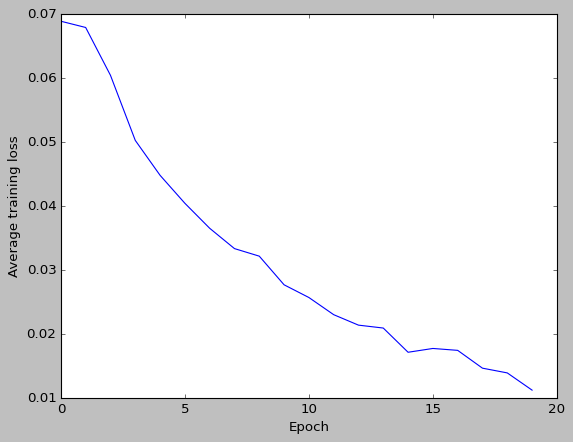

In [34]:
import matplotlib.pyplot as plt
import matplotlib.style
import matplotlib as mpl
mpl.style.use('classic')

plt.plot(means_avg_training_losses)
plt.xlabel('Epoch')
plt.ylabel('Average training loss')
plt.savefig('avg training loss.png', dpi=200)

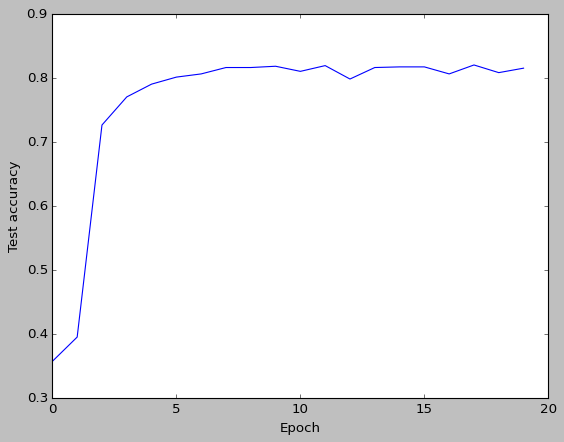

In [35]:
plt.plot(accuracies)
plt.xlabel('Epoch')
plt.ylabel('Test accuracy')
plt.savefig('test accuracy.png', dpi=200)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


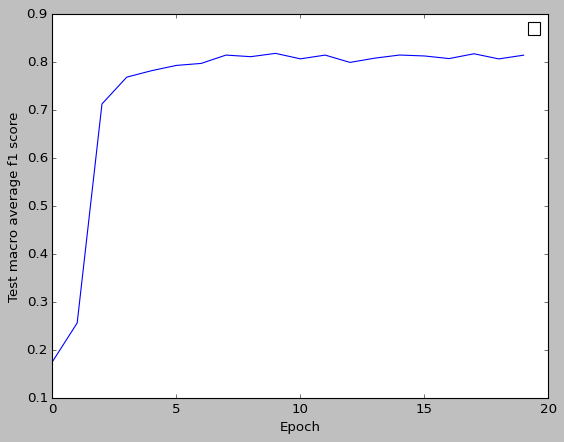

In [36]:
plt.plot(macro_f1_scores)
plt.xlabel('Epoch')
plt.ylabel('Test macro average f1 score')
plt.legend()
plt.savefig('test macro avg f1.png', dpi=200)

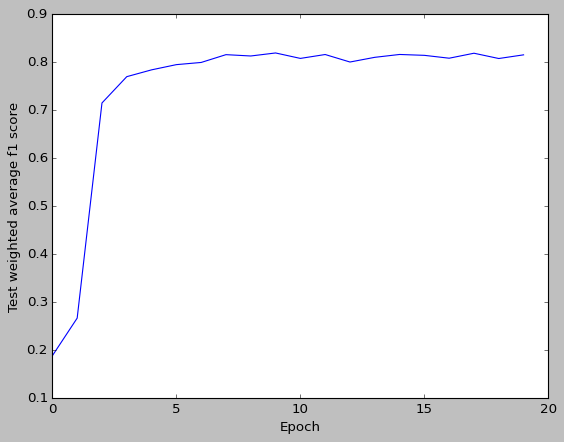

In [37]:
plt.plot(weighted_f1_scores)
plt.xlabel('Epoch')
plt.ylabel('Test weighted average f1 score')
plt.savefig('test weighted avg f1.png', dpi=200)

In [38]:
with open('log_post_train_info.pkl', 'rb') as f:
    post_train_info = pkl.load(f)
    pprint.pprint(post_train_info)

{'max_accuracy': 0.8203592814371258,
 'max_accuracy_index': 17,
 'max_macro_f1': 0.8145254865700325,
 'max_macro_f1_index': 14,
 'max_weighted_f1': 0.8149142982881926,
 'max_weighted_f1_index': 19}


### 5. Demonstration

In [39]:
def prepare_model():
    num_classes = 3
    input_dim = 768

    classifier_head = RobertaClassificationHead(num_classes=num_classes, input_dim=input_dim)
    model = XLMR_BASE_ENCODER.get_model(head=classifier_head)
    
    DEMO_MODEL_PATH = 'model_max_weighted_f1.pth'
    model.load_state_dict(torch.load(DEMO_MODEL_PATH))
    model.to(DEVICE)
    
    print(f'Loaded model to [{DEVICE}] in [{DEMO_MODEL_PATH}]')
    return model

In [40]:
def prepare_text_transform():
    text_transform = torchtext.models.XLMR_LARGE_ENCODER.transform()
    return text_transform

In [41]:
def predict(sentence, model, text_transform, label_map):
    transformed_text = text_transform(sentence)
    out = model(torch.tensor([transformed_text]).to(DEVICE))
    return label_map[torch.argmax(out).item()]

In [42]:
label_map = {
    0: 'negative',
    1: 'neutral',
    2: 'postive'
}

In [43]:
model = prepare_model()
text_transform = prepare_text_transform()

Loaded model to [cpu] in [model_max_weighted_f1.pth]


In [44]:
sample_text = 'Nhờ cao điểm Tết và tăng bay quốc tế, Vietnam Airlines, Vietjet đã báo lãi trở lại, còn Bamboo Airways cũng gần đạt điểm hoà vốn'
predict(sample_text, model, text_transform, label_map)

'postive'